In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
import keras.callbacks as cb
from keras.utils import np_utils, to_categorical
from keras.utils.vis_utils import plot_model

In [19]:
df = pd.read_csv('/Users/dgrubis/Desktop/SpotifyFeatures.csv')

In [21]:
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [22]:
df.genre.unique()

array(['Movie', 'R&B', 'A Capella', 'Alternative', 'Country', 'Dance',
       'Electronic', 'Anime', 'Folk', 'Blues', 'Opera', 'Hip-Hop',
       "Children's Music", 'Children’s Music', 'Rap', 'Indie',
       'Classical', 'Pop', 'Reggae', 'Reggaeton', 'Jazz', 'Rock', 'Ska',
       'Comedy', 'Soul', 'Soundtrack', 'World'], dtype=object)

In [23]:
def combine(genre):
    if genre == 'Hip-Hop' or genre == 'Rap':
        return 'Hip-Hop/Rap'
    if genre == 'Dance' or genre == 'Electronic':
        return 'EDM'
    if genre == 'Indie' or genre == 'Alternative':
        return 'Alternative/Indie'
    if genre == 'Soul' or genre == 'R&B':
        return 'R&B'
    else:
        return genre

In [24]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    new_df = pd.concat([original_dataframe, dummies], axis=1)
    return(new_df)

In [25]:
#df['genre'] = df['genre'].apply(combine)
df = df.drop(['artist_name', 'track_name', 'track_id'], axis = 1)
df = encode_and_bind(df, 'key')
df = encode_and_bind(df, 'mode')
df = encode_and_bind(df, 'time_signature')
specific_genres = ((df['genre'] == 'Pop') | (df['genre'] == 'Country') | (df['genre'] == 'Rap') |
                   (df['genre'] == 'Rock') | (df['genre'] == 'Jazz') | (df['genre'] == 'Electronic') | 
                   (df['genre'] == 'Indie') | (df['genre'] == 'R&B') | (df['genre'] == 'Reggae') | (df['genre'] == 'Classical'))
df = df[specific_genres]

In [26]:
#df.to_csv('/Users/dgrubis/Desktop/Spotify.csv') #for ggplot

In [27]:
features = df.drop(['genre', 'key', 'mode', 'time_signature'], axis = 1)
features_fi = df.drop(['genre', 'key', 'mode', 'time_signature'], axis = 1) #used as labels for feature importance plots
#target_svm = df[['genre']].values.ravel() #target shape for non-NN models (rf, svm, adaboost)
features = preprocessing.scale(features) #scale features
target = to_categorical(df.genre.factorize()[0], 10) #target shape for NN

In [28]:
le = preprocessing.LabelEncoder()
target_svm = le.fit_transform(df[['genre']].values.ravel())

In [29]:
df.genre.unique()

array(['R&B', 'Country', 'Electronic', 'Rap', 'Indie', 'Classical', 'Pop',
       'Reggae', 'Jazz', 'Rock'], dtype=object)

In [30]:
df.columns

Index(['genre', 'popularity', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'key_A', 'key_A#',
       'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F',
       'key_F#', 'key_G', 'key_G#', 'mode_Major', 'mode_Minor',
       'time_signature_0/4', 'time_signature_1/4', 'time_signature_3/4',
       'time_signature_4/4', 'time_signature_5/4'],
      dtype='object')

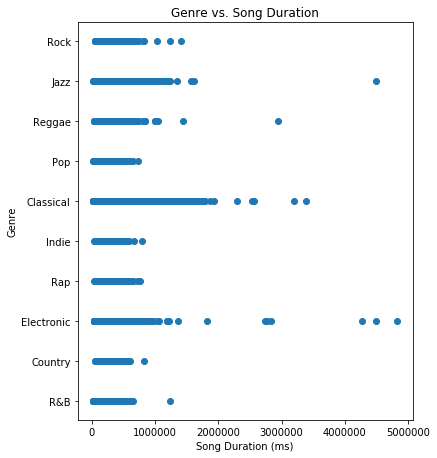

In [31]:
plt.scatter(df['duration_ms'], df['genre'])
plt.subplots_adjust(bottom=-0.5)
plt.xlabel('Song Duration (ms)')
plt.ylabel('Genre')
plt.title('Genre vs. Song Duration')
plt.show()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, train_size = 0.75, shuffle = True)

In [34]:
len(X_test)

22984

In [45]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(features, target_svm, test_size=0.25, train_size = 0.75, shuffle = True)

In [46]:
# NN Architecture
model = Sequential()

model.add(Dense(1000, input_dim = 30))
model.add(Activation('relu'))

model.add(Dense(700))
model.add(Dropout(0.35))
model.add(Activation('relu'))

model.add(Dense(250))
model.add(Dropout(0.15))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))
plot_model(model, to_file='/Users/dgrubis/Desktop/model_plot.png', show_shapes=True, show_layer_names=True)

rms = RMSprop()
model.compile(loss = 'categorical_crossentropy', optimizer = rms, metrics = ['accuracy'])

In [47]:
history = model.fit(X_train, y_train, nb_epoch = 15, batch_size = 256, validation_data = (X_test, y_test), verbose = 2)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 68950 samples, validate on 22984 samples
Epoch 1/15
 - 20s - loss: 1.3637 - acc: 0.4973 - val_loss: 1.2902 - val_acc: 0.5158
Epoch 2/15
 - 18s - loss: 1.2485 - acc: 0.5367 - val_loss: 1.2312 - val_acc: 0.5407
Epoch 3/15
 - 21s - loss: 1.2111 - acc: 0.5478 - val_loss: 1.2154 - val_acc: 0.5402
Epoch 4/15
 - 24s - loss: 1.1831 - acc: 0.5551 - val_loss: 1.1959 - val_acc: 0.5480
Epoch 5/15
 - 20s - loss: 1.1644 - acc: 0.5644 - val_loss: 1.1707 - val_acc: 0.5580
Epoch 6/15
 - 19s - loss: 1.1480 - acc: 0.5688 - val_loss: 1.1983 - val_acc: 0.5529
Epoch 7/15
 - 19s - loss: 1.1368 - acc: 0.5721 - val_loss: 1.1694 - val_acc: 0.5623
Epoch 8/15
 - 20s - loss: 1.1211 - acc: 0.5761 - val_loss: 1.1922 - val_acc: 0.5526
Epoch 9/15
 - 18s - loss: 1.1125 - acc: 0.5798 - val_loss: 1.1717 - val_acc: 0.5617
Epoch 10/15
 - 20s - loss: 1.1031 - acc: 0.5835 - val_loss: 1.1926 - val_acc: 0.5561
Epoch 11/15
 - 19s - loss: 1.0953 - acc: 0.5863 - val_loss: 1.1787 - val_acc: 0.5584
Epoch 12/15
 - 19s - los

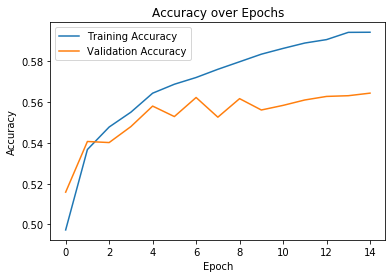

In [61]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

In [49]:
print("Accuracy of Neural Network: ", round(model.evaluate(X_test, y_test, batch_size = 16)[1], 2))

22984/22984 [==============================] - 5s 237us/step
Accuracy of Neural Network:  0.56


In [50]:
rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')
rf.fit(X_train_svm, y_train_svm)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [51]:
y_pred = rf.predict(X_test_svm)

In [52]:
print("Accuracy of the Random Forest: ", round(accuracy_score(y_test_svm, y_pred), 2))

Accuracy of the Random Forest:  0.49


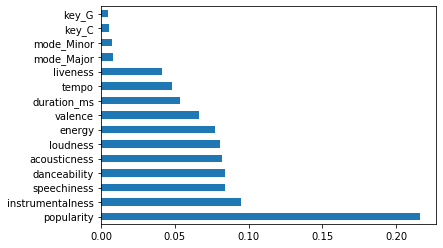

In [53]:
feat_importances = pd.Series(rf.feature_importances_, index=features_fi.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [54]:
svm = SVC(C = 3.0, kernel = 'rbf', decision_function_shape = 'ovo', gamma = 'scale', probability = True)
svm.fit(X_train_svm, y_train_svm)

SVC(C=3.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [55]:
y_pred = svm.predict(X_test_svm)

In [60]:
print("Accuracy of the RBF Kernel SVM: ", accuracy_score(y_test_svm, y_pred))

Accuracy of the RBF Kernel SVM:  0.5515140967629656


In [57]:
confusion_matrix = confusion_matrix(y_test_svm, y_pred)
print(confusion_matrix)
print("Precision: ", precision_recall_fscore_support(y_test_svm, y_pred, average='macro')[0])
print("Recall: ", precision_recall_fscore_support(y_test_svm, y_pred, average='macro')[1])
print("F-Score: ", precision_recall_fscore_support(y_test_svm, y_pred, average='macro')[2])

[[2038   41   88   17  142    0    6    0    5    4]
 [  13 1195   59  169   88   73   97   28  116  271]
 [  42   85 1533   53  240   22   68   57  209   48]
 [  11  262   76  774   98  243  303  173   29  425]
 [ 176  142  285  129 1272   10  125   23  214   39]
 [   1   13    9  168    4 1130   65  535    5  447]
 [   1  170   99  247  100  274  768  338  141   74]
 [   0   12   17  117    9  474  245 1283   17  185]
 [   2  146  142   33  124   19  144   69 1471   50]
 [  11  140   12  351   30  305   67   72   20 1212]]
Precision:  0.5518339769914556
Recall:  0.5518649869406025
F-Score:  0.5503802801272014


In [58]:
#Too expensive to run


#C_range = np.logspace(-2, 5, num = 8, base = 10)
#gamma_range = np.logspace(-5, 2, num = 8, base = 10)
#param_grid = dict(gamma=gamma_range, C=C_range)
#cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25)
#grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
#grid.fit(X_train_svm, y_train_svm)

#print("The best parameters are %s with a score of %0.2f"
      #% (grid.best_params_, grid.best_score_))

In [59]:
#scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     #len(gamma_range))

#plt.figure(figsize=(8, 6))
#plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
#plt.xlabel('gamma')
#plt.ylabel('C')
#plt.colorbar()
#plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
#plt.yticks(np.arange(len(C_range)), C_range)
#plt.title('Validation accuracy')
#plt.show()